In [1]:
import numpy as np
#from celerite2.jax.terms import RealTerm,SHOTerm,TermSum
from tinygp.kernels.quasisep import Celerite,Matern32
from mind_the_gaps.simulator import Simulator
from mind_the_gaps.lightcurves import GappyLightcurve
import matplotlib.pyplot as plt
from mind_the_gaps import GPModelling
from mind_the_gaps.utils.stats import aicc
from scipy.stats import norm, ks_1samp
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)
from mind_the_gaps.gp.tinygp_gaussian_process import TinyGP
import numpyro.distributions as dist
import jax.numpy as jnp
import corner
import tinygp
plt.rcParams['figure.figsize'] = [16, 8]
np.random.seed(10)

def flatten_terms(kernel):
            if isinstance(kernel, tinygp.kernels.quasisep.Sum):
                return flatten_terms(kernel.kernel1) + flatten_terms(kernel.kernel2)
            elif hasattr(kernel, "terms"):
                flat_terms = []
                for term in kernel.terms:
                    flat_terms.extend(flatten_terms(term))
                return flat_terms
            else:
                return [kernel]

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Let's first generate a lightcurve with a complex PSD, a combination of a DRW, Matern-3/2 and a QPO (Lorentzian)

log variance of the QPO: 4.61, log_Q: 4.38, log omega: -1.38
Truth parameters: [  4.60517019  -6.45617257  -1.38099876   4.60517019  -1.85100239
   4.60517019  23.11044905   0.08459812 -18.42068074]
Kernel: Sum(
  kernel1=Sum(
    kernel1=Celerite(a=f64[], b=-1e-10, c=f64[], d=f64[]),
    kernel2=Celerite(a=weak_f64[], b=-1e-10, c=weak_f64[], d=-1e-10)
  ),
  kernel2=Celerite(a=f64[], b=f64[], c=f64[], d=f64[])
)


/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


[<function KernelTermSpec.get_psd.<locals>.psd_fn at 0x32cdfe200>, <function KernelTermSpec.get_psd.<locals>.psd_fn at 0x32ce0cf40>, <function KernelTermSpec.get_psd.<locals>.psd_fn at 0x32ce0cd60>]


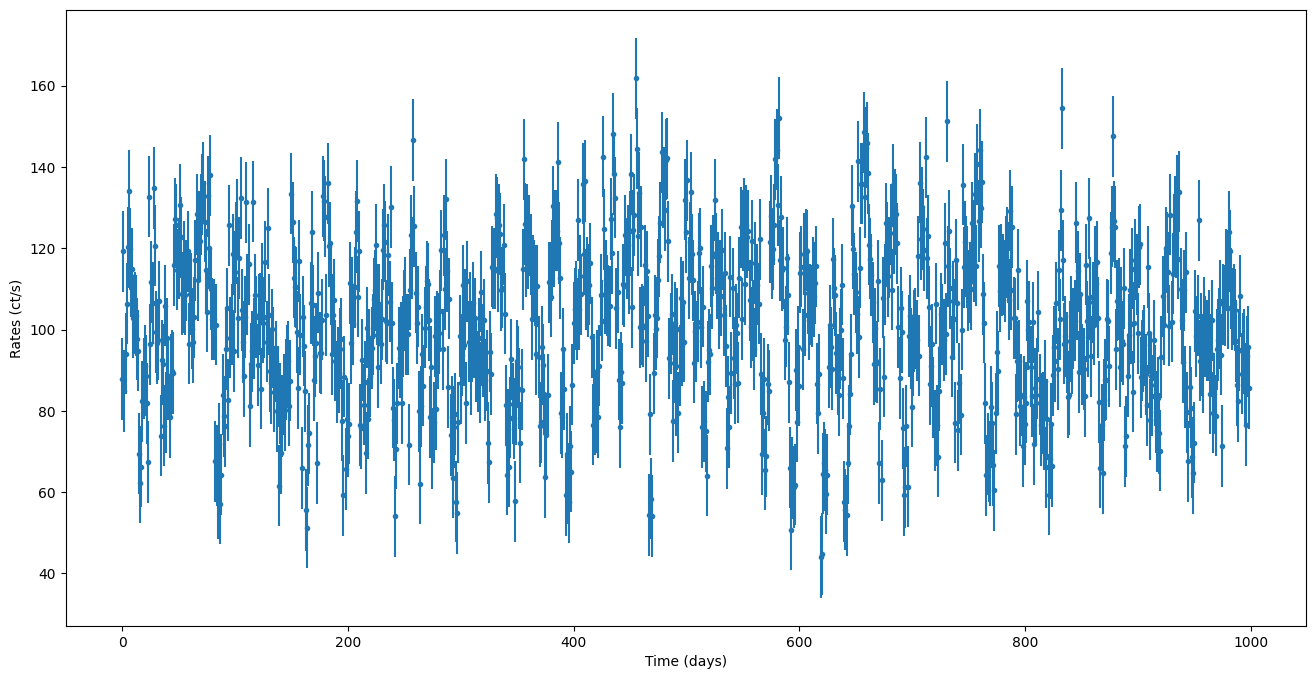

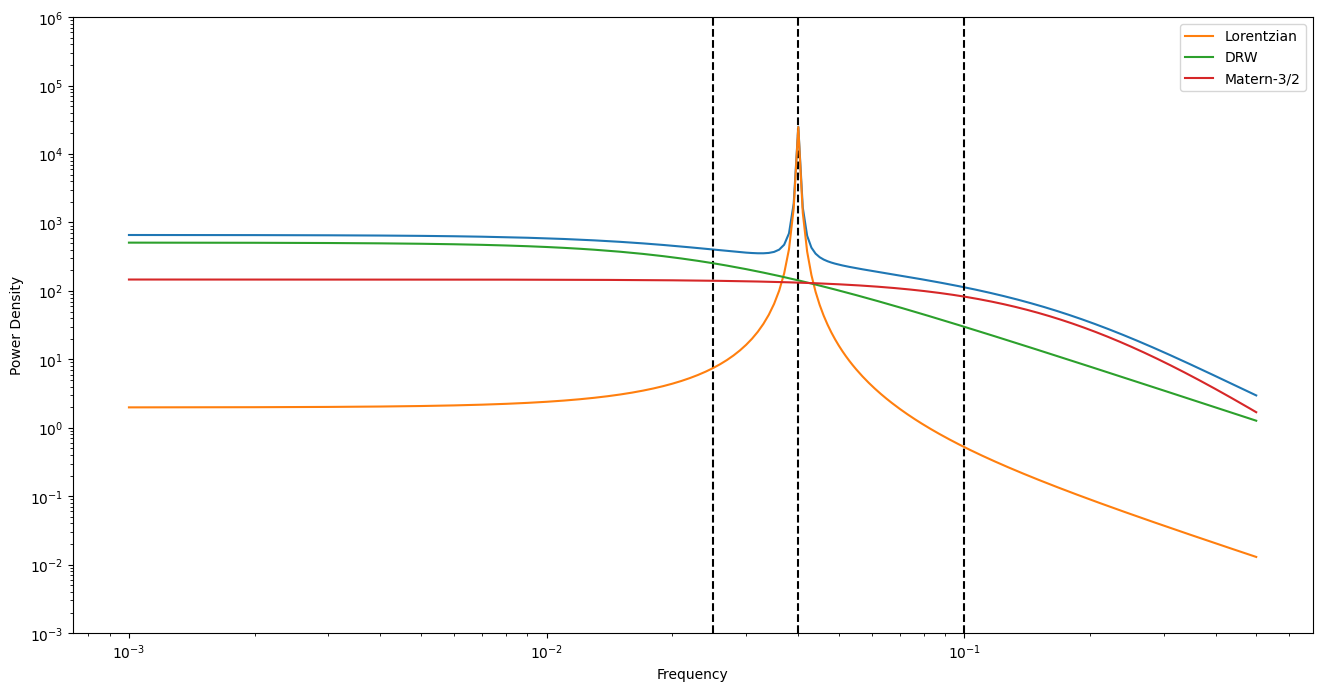

In [ ]:
times = np.arange(0, 1000)
exposure = np.diff(times)[0]

# Parameters
P_qpo = 25
w = 2 * np.pi / P_qpo
mean = 100
rms = 0.1
variance_drw = (mean * rms) ** 2
P_drw = 40
w_bend = 2 * np.pi / P_drw
log_variance_qpo = np.log(variance_drw)
log_sigma_matern = np.log(np.sqrt(variance_drw))
P_matern = 10
log_rho_matern = np.log(P_matern / (2 * np.pi))
Q = 80
log_Q = np.log(Q)
log_d = np.log(w)
c = 0.5 * w / Q



eps = 1e-8

w0 = np.sqrt(3) * np.exp(-log_rho_matern)  # c parameter
S0 = np.exp(2 * log_sigma_matern) / w0  # amplitude scaling

a_mat = w0 * S0  # = sigma^2
b_mat = (w0**2) * S0 / eps  # large value ~ sigma^2 * w0 / eps
c_mat = w0  # decay rate
d_mat = eps  # tiny imaginary freq

labels = ["Lorentzian", "DRW", "Matern-3/2"]
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_Q: {log_Q:.2f}, log omega: {log_d:.2f}")

kernel_spec = KernelSpec(
    terms=[


        KernelTermSpec(
            term_class=Celerite,
            parameters={
                "a": KernelParameterSpec(
                    value=log_variance_qpo, prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
                "b": KernelParameterSpec(value=0.0, zeroed=True),
                "c": KernelParameterSpec(
                    value=np.log(c), prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
                "d": KernelParameterSpec(
                    value=log_d, prior=dist.Uniform, bounds=(1e-5, 50.0)
                ),
            },
        ),
    


        # RealTerm (DRW / bending power law)

            KernelTermSpec(
                term_class=Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10.0, 50.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                    "d": KernelParameterSpec(value=-1e20, zeroed=True),
                },
            )

,                   KernelTermSpec(
            term_class=Celerite,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "b": KernelParameterSpec(
                    value=np.log(b_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "c": KernelParameterSpec(
                    value=np.log(c_mat), bounds=(1e-12, 1e12), prior=dist.Uniform
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_mat), bounds=(1e-12, 1e-4), prior=dist.Uniform
                ),
            },
            eps=eps,
        )
    ]
    
    )

kernel = kernel_spec.get_kernel()


truth = kernel_spec.get_param_array()
print(f"Truth parameters: {truth}")
print(f"Kernel: {kernel}")

        
psd_model = kernel_spec.get_psd_from_kernel(freq_in_hz=False)

#psd_tiny = np.array(psd_fn(self.freqs))
#psd_model = kernel.get_psd


# create simulator object with Gaussian noise
simulator = Simulator(psd_model, times, np.ones(len(times)) * exposure, mean, pdf="Gaussian", 
                      sigma_noise=10, extension_factor = 2)

# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)
input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=exposure)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# plot PSD
df = 1 / input_lc.duration
nyquist = 1 / (2 * exposure)
freqs = np.arange(df, nyquist, df)
fig = plt.figure()
# remember angular freqs for the PSD models
plt.plot(freqs, psd_model(2 * np.pi * freqs))
plt.ylim(1e-3,1e6)
for p in [P_qpo, P_drw, P_matern]:
    plt.axvline(1 / p, ls="--", color="black")

plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.xscale("log")
plt.yscale("log")
print(kernel_spec.get_term_psds())
for i,term_psd in enumerate(kernel_spec.get_term_psds(freq_in_hz=False)):#enumerate(kernel.terms):
    #print("i",term)
    plt.plot(freqs, term_psd(2 * np.pi * freqs), label=labels[i])
plt.legend()

lc_variance = np.var(input_lc.y)

Dummy methods to construct reasonable parameter bounds

In [3]:
def bounds_variance(variance, margin=15):
    return np.log(variance/margin), np.log(variance * margin)

def bounds_bend(duration, dt):
    nyquist = 1 / (2 * dt)
    return np.log(2 * np.pi/duration), np.log(nyquist * 2 * np.pi)

# Define models to be tested and their bounds based on the data

In [4]:
variance_bounds = bounds_variance(lc_variance)
print(variance_bounds)
bend_bounds = bounds_bend(input_lc.duration, exposure)
print(bend_bounds)
sigma_bounds = bounds_variance(np.sqrt(lc_variance))
timescale_bounds = ((np.log(exposure), np.log(input_lc.duration)))
print(timescale_bounds)
# limit Q lower bound to "periodic" components
Q_bounds = (np.log(1.5), np.log(1000))

log_var = np.log(lc_variance)

real_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=float(log_var), bounds=variance_bounds,prior=dist.Uniform
                    ),
                    "b": KernelParameterSpec(value=-1e20,zeroed=True),
                    "c": KernelParameterSpec(value=float(np.log(2 * np.pi / 50)), bounds=bend_bounds,prior=dist.Uniform),
                    "d": KernelParameterSpec(value=-1e20,zeroed=True)
                },
            )])
log_S0=np.log(10)
log_Q = np.log(100)
log_omega0=np.log(2*np.pi/10)
S0 = np.exp(log_S0)
Q = np.exp(log_Q)
w0 = np.exp(log_omega0)

a = S0
b = 0.0
c = 0.5 * w0 / Q
d_pos = w0
d_neg = -w0
lorentzian_spec = KernelSpec(
    terms=[
        KernelTermSpec(
            term_class=Celerite,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
                "b": KernelParameterSpec(value=b, zeroed=True),
                "c": KernelParameterSpec(
                    value=np.log(c), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_pos), prior=dist.Uniform, bounds=(-10, 50.0)
                ),
            },
        ),
    ]
)
log_sigma = np.log(np.sqrt(lc_variance))
log_rho = np.log(10)
eps = 1e-8


w0 = np.sqrt(3) * np.exp(-log_rho_matern)  # c parameter
S0 = np.exp(2 * log_sigma_matern) / w0  # amplitude scaling

a_mat = w0 * S0  # = sigma^2
b_mat = (w0**2) * S0 / eps  # large value ~ sigma^2 * w0 / eps
c_mat = w0  # decay rate
d_mat = eps  # tiny imaginary freq
matern_spec = KernelSpec(
    terms=[KernelTermSpec(
            term_class=Celerite,
            parameters={
                "a": KernelParameterSpec(
                    value=np.log(a_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "b": KernelParameterSpec(
                    value=np.log(b_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "c": KernelParameterSpec(
                    value=np.log(c_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
                "d": KernelParameterSpec(
                    value=np.log(d_mat), bounds=(-10, 50), prior=dist.Uniform
                ),
            },
            eps=eps,
        )])

models = [real_spec, 
          matern_spec,
         lorentzian_spec + real_spec,
         lorentzian_spec + real_spec +matern_spec
          ,]

(3.2833149775087467, 8.699415379713166)
(-5.068877712239209, 1.1447298858494002)
(0.0, 6.906754778648554)


# Derive AICc and p-values for the standarized residuals following a normal (0, 1) distribution

In [ ]:

aiccs = []
pvalues = []
gps = []
for kernel_spec in models:
    print(kernel_spec)
    print("------------------------------------------------------------------")
    gp = GPModelling( kernel_spec=kernel_spec, lightcurve=input_lc)
    # here we first minimize the likelihood and then run a small MCMC to ensure we find the maximum of the loglikelihood
    gp.derive_posteriors(fit=True, max_steps=4000,num_chains=20,converge_steps=500, num_warmup=1000,progress=True,aies=True)
    best_pars = gp.max_parameters
    gp.parameters = best_pars
    std_res = gp.standardized_residuals(include_noise=False)
    pvalue = ks_1samp(std_res, norm.cdf).pvalue
    AICc = aicc(gp.max_loglikelihood, gp.k, input_lc.n)
    print(f"p-value:{pvalue:.3f} | AICC: {AICc:.2f}")
    pvalues.append(pvalue)
    aiccs.append(AICc)
    gps.append(gp)
    

KernelSpec(terms=[KernelTermSpec(term_class=<class 'tinygp.kernels.quasisep.Celerite'>, parameters=OrderedDict([('a', KernelParameterSpec(value=5.991365178610956, fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(3.2833149775087467, 8.699415379713166))), ('b', KernelParameterSpec(value=-1e-10, fixed=True, prior=None, bounds=None)), ('c', KernelParameterSpec(value=-2.0741459390188006, fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-5.068877712239209, 1.1447298858494002))), ('d', KernelParameterSpec(value=-1e-10, fixed=True, prior=None, bounds=None))]))])
------------------------------------------------------------------


sample: 100%|██████████| 500/500 [00:02<00:00, 190.81it/s, acc. prob=0.53]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 557.45it/s, acc. prob=0.55]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 553.62it/s, acc. prob=0.55]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 544.82it/s, acc. prob=0.55]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 552.43it/s, acc. prob=0.54]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 553.52it/s, acc. prob=0.55]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 554.18it/s, acc. prob=0.55]


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:00<00:00, 529.77it/s, acc. prob=0.55]


MCMC not converged after 4000 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:529: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


[-1.08005873e+00  2.19670344e+00 -1.57856728e+00 -6.98785995e-01
 -1.36883796e-01  4.78226084e-01  1.56677080e+00  9.98552903e-02
 -1.96754944e-01  4.69123287e-01 -4.51388583e-01  5.12012945e-02
  3.26314022e-01  2.11319229e-01  7.84348360e-01 -1.03580287e+00
 -1.19597044e+00 -9.16165762e-01  2.71173000e-01  3.04888955e-01
  3.82049517e-01  1.43026686e-01 -5.26581436e-01 -2.83575687e+00
  3.53642770e+00 -1.19684323e+00  3.38204046e-01 -8.03528546e-01
  2.02866360e+00  7.57975738e-01 -7.69430576e-01 -4.63283626e-01
 -1.17686903e-01  1.35574529e+00 -1.90100016e+00  3.96063107e-01
  3.03034432e-01 -1.48238152e+00  1.74815205e+00 -1.27951983e+00
  8.83666450e-01 -7.94870938e-02 -9.79150124e-01  7.19230981e-03
 -3.08641496e-01 -1.16154466e+00  7.07623859e-01  1.08803471e+00
  6.75450728e-01 -4.98266513e-01 -2.74333291e-01  1.10775237e+00
  4.62617188e-01 -6.23663948e-01 -3.47929368e-01  5.45805941e-01
 -3.32738682e-01  7.45793943e-02  1.07871680e+00 -1.19112575e+00
  3.27865693e-01  4.17292

sample: 100%|██████████| 500/500 [00:02<00:00, 169.23it/s, acc. prob=0.39]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 427.58it/s, acc. prob=0.40]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 448.56it/s, acc. prob=0.38]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 447.48it/s, acc. prob=0.39]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 447.42it/s, acc. prob=0.39]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 444.46it/s, acc. prob=0.38]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 447.58it/s, acc. prob=0.39]


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 449.36it/s, acc. prob=0.39]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:529: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.
[-1.05694862e+00  2.93979935e+00 -2.07304283e+00 -1.13943662e+00
 -3.62809338e-01  5.39966139e-01  1.94619226e+00 -6.51065574e-02
 -5.48253688e-01  3.05955168e-01 -8.32020766e-01 -7.60814967e-02
  4.42921736e-01  4.36312567e-01  1.18441854e+00 -1.26653319e+00
 -1.54372675e+00 -1.07716259e+00  6.05741173e-01  7.18307994e-01
  7.49975908e-01  2.56741916e-01 -8.81657181e-01 -3.83504326e+00
  4.48133880e+00 -1.67797394e+00  7.94294758e-02 -1.30203135e+00
  2.48232870e+00  8.27883668e-01 -1.28044092e+00 -8.56610776e-01
 -2.09403695e-01  1.75223955e+00 -2.46012913e+00  5.40410259e-01
  4.73759486e-01 -1.77794268e+00  2.43191506e+00 -1.41670691e+00
  1.36043934e+00  9.11408393e-02 -1.15510029e+00  7.76690735e-02
 -3.99582427e-01 -1.52874038e+00  9.68124605e-01  1.50997127e+00
  8.40741259e-01 -8.22488625e-01 -4.98745554e-01  1.41464016e+00
  5.93827067e-01 -8.70598637e-01 -4.64660471e-01  7.87964446e-01
 -2.75573819e-01  3.33521436e-01  1.64976889e+00 -1.2

sample: 100%|██████████| 500/500 [00:09<00:00, 54.79it/s, acc. prob=0.40]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 70.21it/s, acc. prob=0.37]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:06<00:00, 71.70it/s, acc. prob=0.31]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 69.14it/s, acc. prob=0.28]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 70.08it/s, acc. prob=0.24]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 70.37it/s, acc. prob=0.21]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 69.20it/s, acc. prob=0.21]


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:07<00:00, 70.12it/s, acc. prob=0.21]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:529: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.
[-1.36690615e+00  2.25832952e+00 -2.03710463e+00 -1.07973850e+00
 -3.49212109e-01  4.78420073e-01  1.78565841e+00  1.44983072e-01
 -1.94100274e-01  5.72965378e-01 -4.30384696e-01  1.81086570e-01
  5.44465636e-01  4.38517050e-01  1.03288566e+00 -1.11430699e+00
 -1.36688071e+00 -1.02827698e+00  3.67758096e-01  4.33687748e-01
  4.80196960e-01  1.13145050e-01 -7.68543507e-01 -3.35506345e+00
  3.86990947e+00 -1.45001106e+00  2.11681276e-01 -1.01873770e+00
  2.22259149e+00  7.69820055e-01 -1.03336402e+00 -7.03406757e-01
 -2.45557876e-01  1.44080254e+00 -2.20847658e+00  4.23600281e-01
  3.82960578e-01 -1.56197572e+00  2.12292377e+00 -1.24697822e+00
  1.17359400e+00  5.43810790e-02 -1.02094088e+00  5.38369075e-02
 -3.29892602e-01 -1.28351597e+00  8.77577398e-01  1.33730710e+00
  8.05666428e-01 -6.07892341e-01 -3.84854969e-01  1.17697982e+00
  4.11176745e-01 -8.71646776e-01 -5.57655676e-01  4.93600781e-01
 -4.44635954e-01  7.78214616e-02  1.24780955e+00 -1.2

sample: 100%|██████████| 500/500 [00:12<00:00, 41.51it/s, acc. prob=0.35]


MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 52.30it/s, acc. prob=0.31]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 54.84it/s, acc. prob=0.29]


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 52.38it/s, acc. prob=0.27]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 52.99it/s, acc. prob=0.26]


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 52.61it/s, acc. prob=0.25]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 53.09it/s, acc. prob=0.25]


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:09<00:00, 53.02it/s, acc. prob=0.25]
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:529: UserWarning: The chains did not converge after 4000 iterations!
  warnings.warn(


MCMC not converged after 4000 steps.
[-1.34968562e+00  2.25968722e+00 -1.98720658e+00 -1.03923732e+00
 -3.08123059e-01  5.18127063e-01  1.81121315e+00  1.73338076e-01
 -1.75064885e-01  5.76320190e-01 -4.25458131e-01  1.75877829e-01
  5.34667148e-01  4.28503631e-01  1.01151622e+00 -1.12609667e+00
 -1.38241356e+00 -1.04185425e+00  3.51008888e-01  4.23773855e-01
  4.72640344e-01  1.07594179e-01 -7.71251632e-01 -3.32370125e+00
  3.84997782e+00 -1.41593551e+00  2.26629697e-01 -9.81815206e-01
  2.24100031e+00  8.02906943e-01 -9.90907167e-01 -6.64684731e-01
 -2.05118924e-01  1.46247585e+00 -2.16211825e+00  4.38901343e-01
  3.91713287e-01 -1.54254596e+00  2.10151854e+00 -1.24273005e+00
  1.14831648e+00  3.32379319e-02 -1.03951271e+00  2.24508066e-02
 -3.60683144e-01 -1.30495084e+00  8.44185583e-01  1.30707502e+00
  7.78923242e-01 -6.23327513e-01 -3.94947245e-01  1.16397453e+00
  4.09455253e-01 -8.62574523e-01 -5.48384738e-01  4.96803477e-01
 -4.32638702e-01  8.42788245e-02  1.23812639e+00 -1.2

# Finally our best-fit model is that which minimizes the AICc

[ 4.29912633 -6.20575441 -1.39153218  5.28224156 -1.56851824  0.36243898
 -0.96897219 28.05422513 22.07416017]
Best model KernelSpec(terms=[KernelTermSpec(term_class=<class 'tinygp.kernels.quasisep.Celerite'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(4.29912633, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('b', KernelParameterSpec(value=-1e-10, fixed=True, prior=None, bounds=None)), ('c', KernelParameterSpec(value=Array(-6.20575441, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0))), ('d', KernelParameterSpec(value=Array(-1.39153218, dtype=float64), fixed=False, prior=<class 'numpyro.distributions.continuous.Uniform'>, bounds=(-10, 50.0)))])), KernelTermSpec(term_class=<class 'tinygp.kernels.quasisep.Celerite'>, parameters=OrderedDict([('a', KernelParameterSpec(value=Array(5.28224156, dtype=float64), fixed=False, prior=<class 'numpyro.distributi

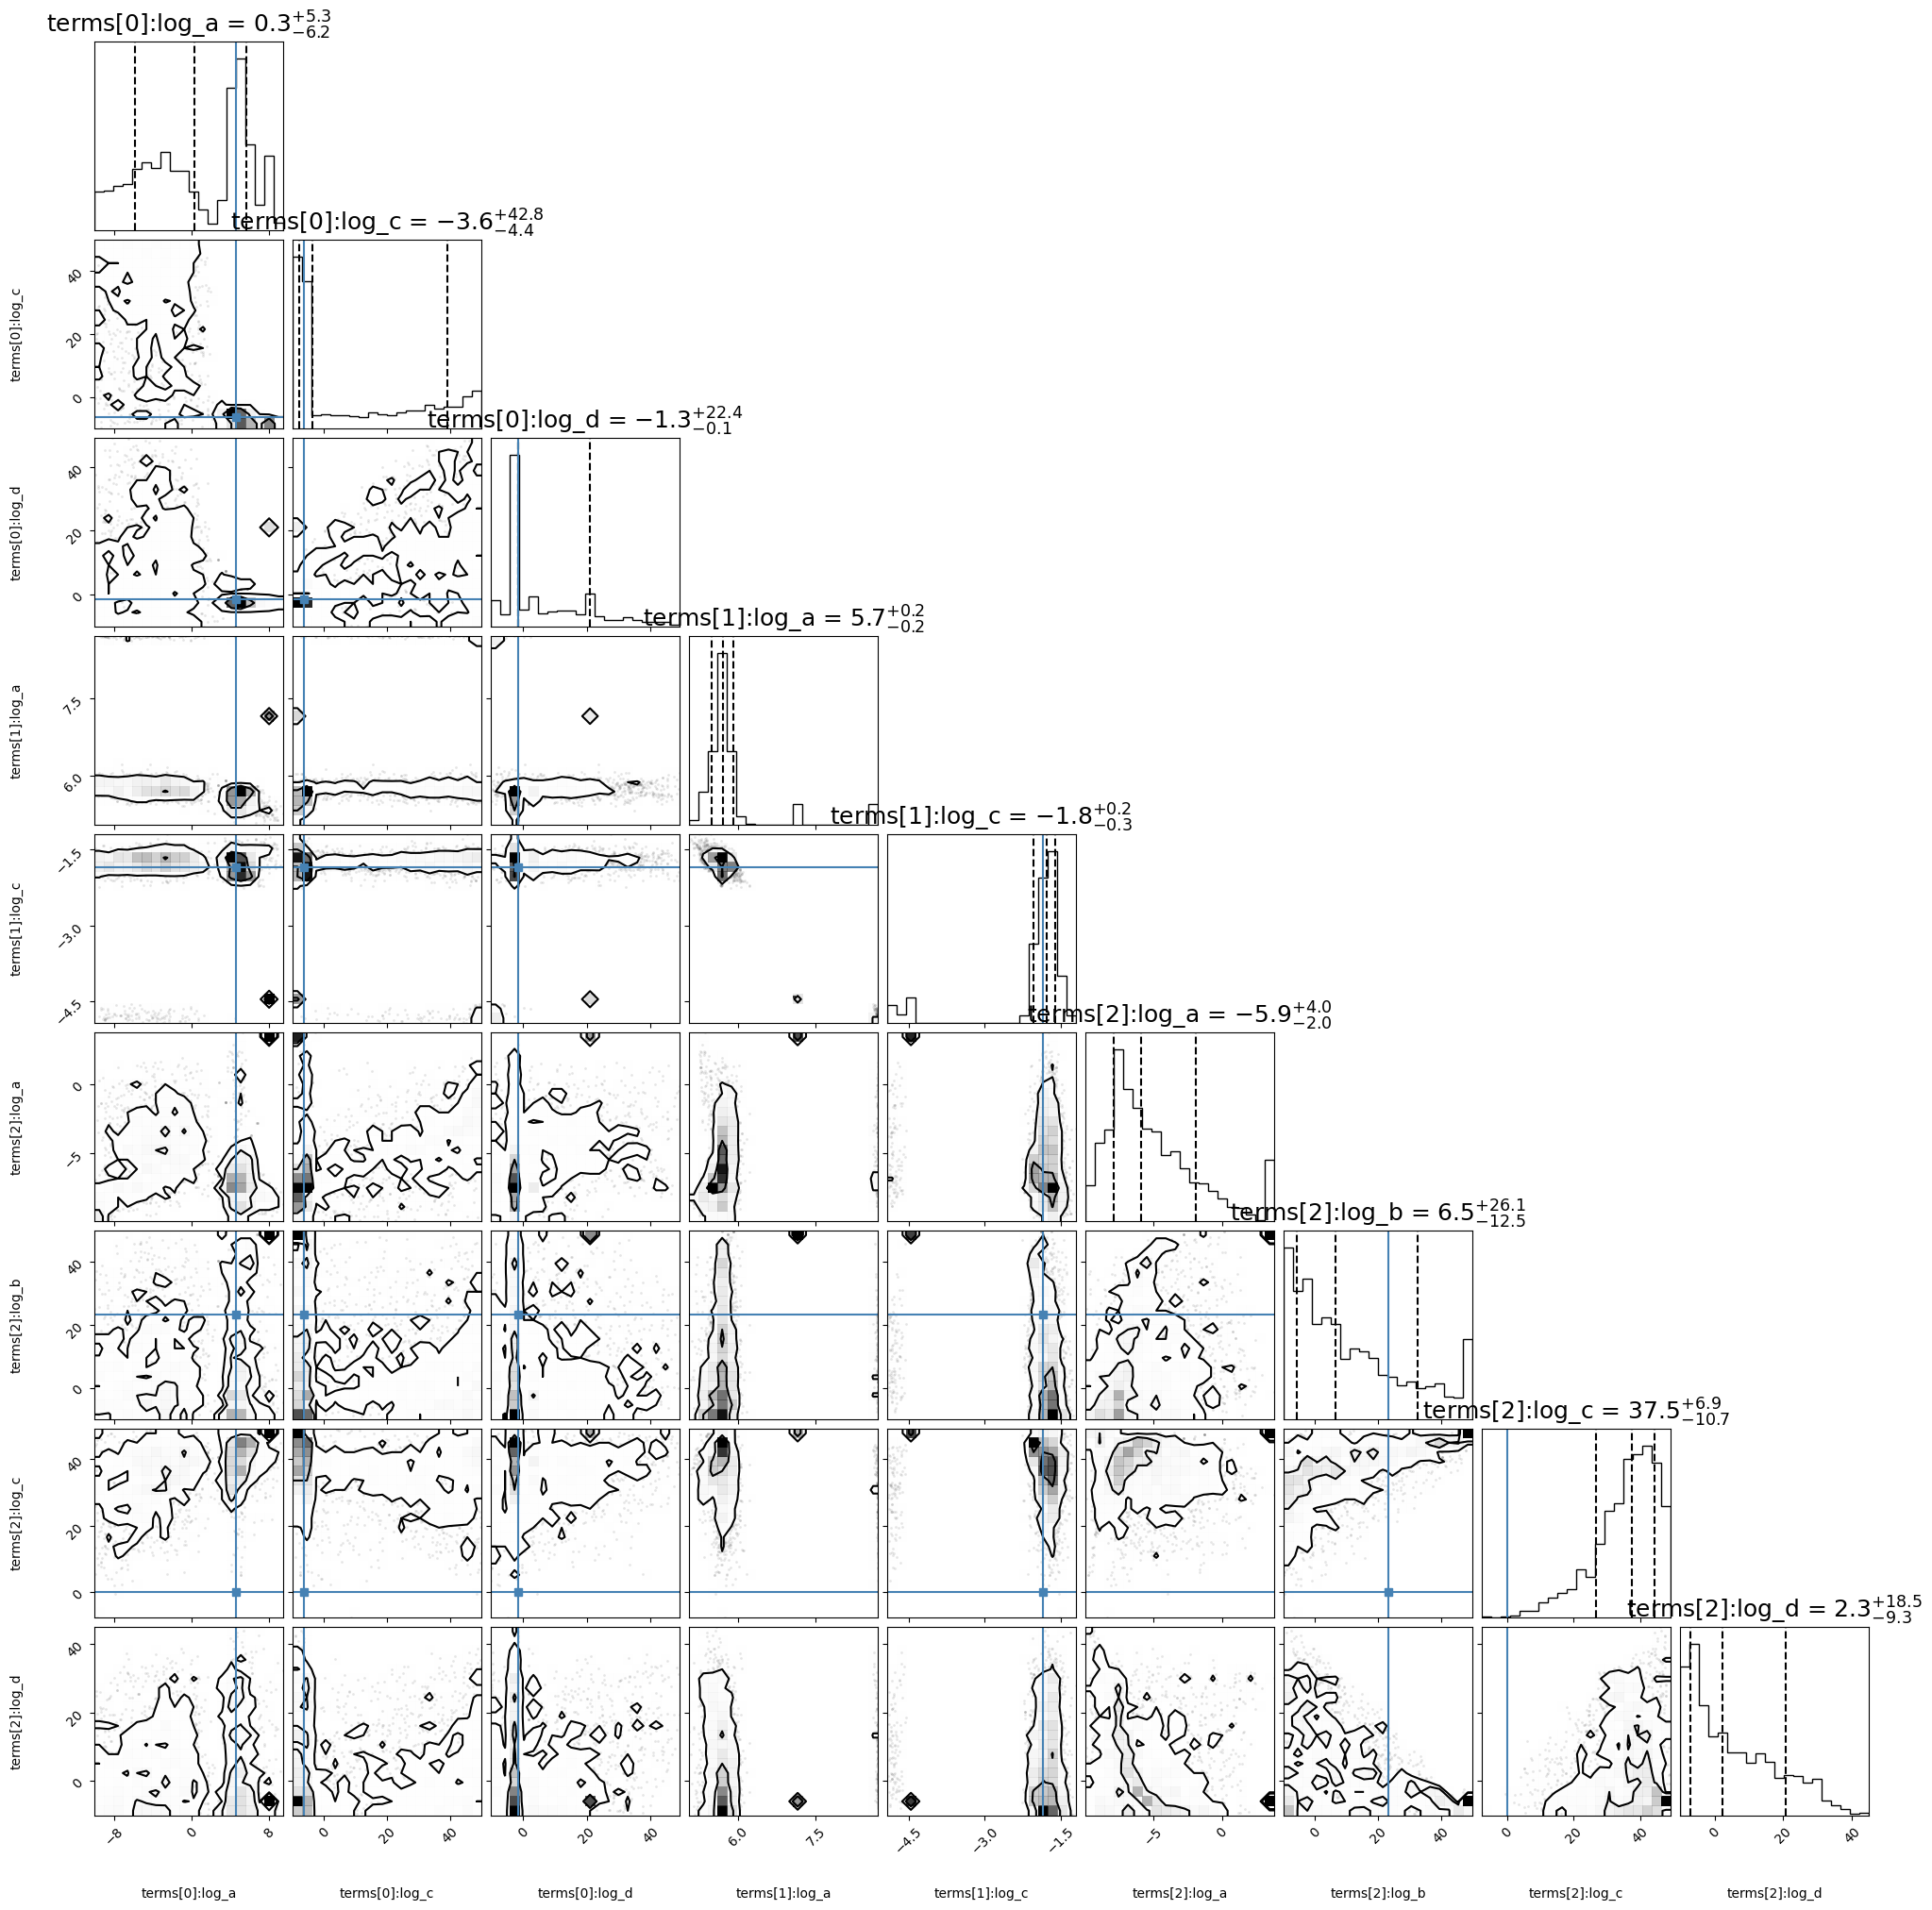

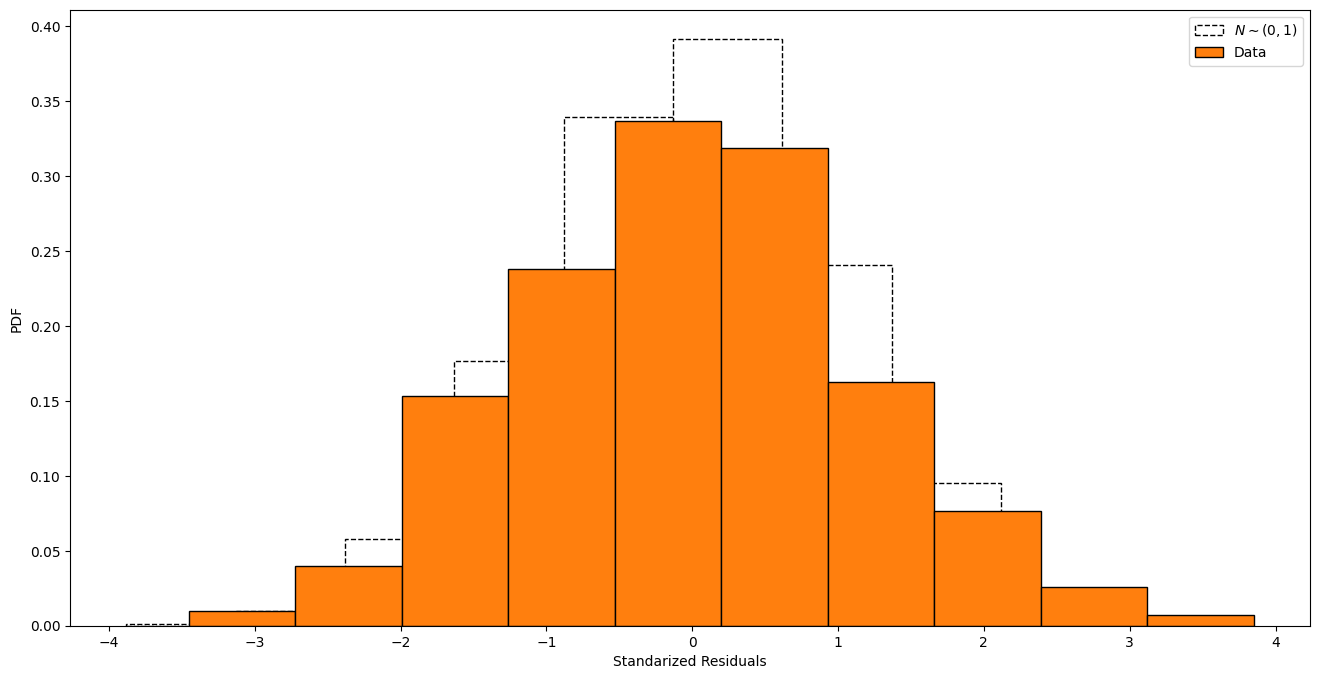

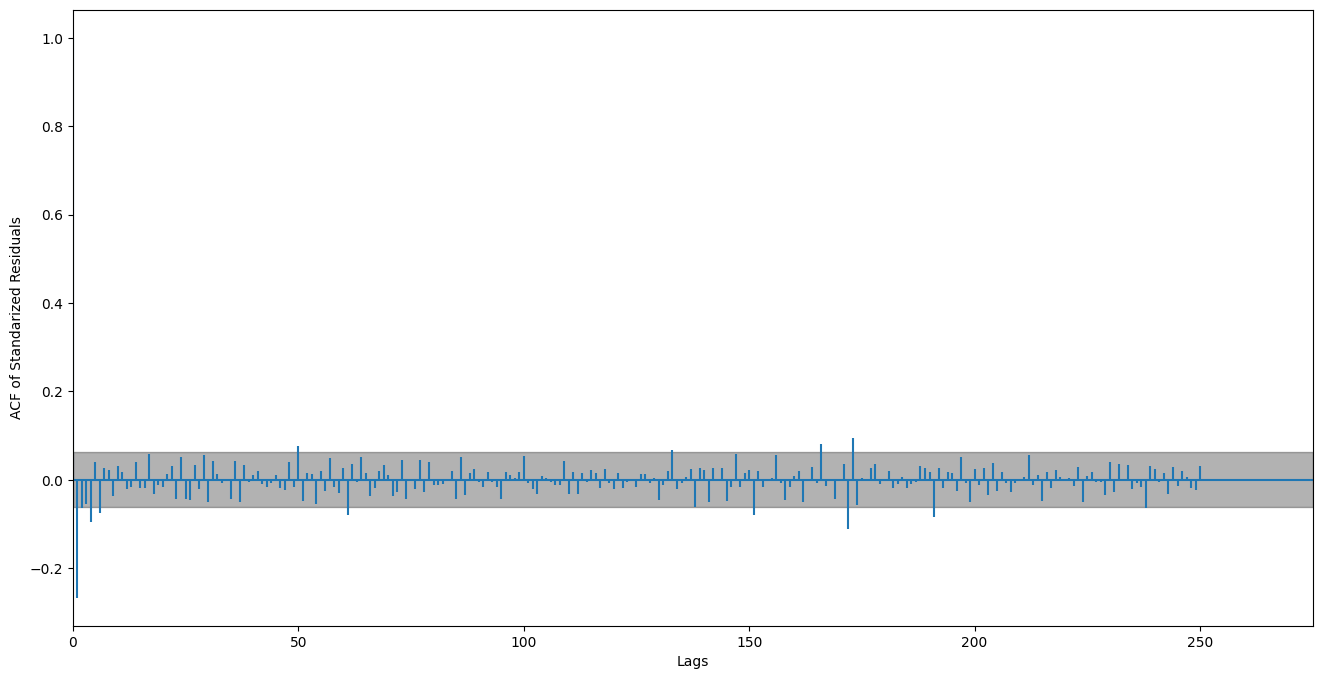

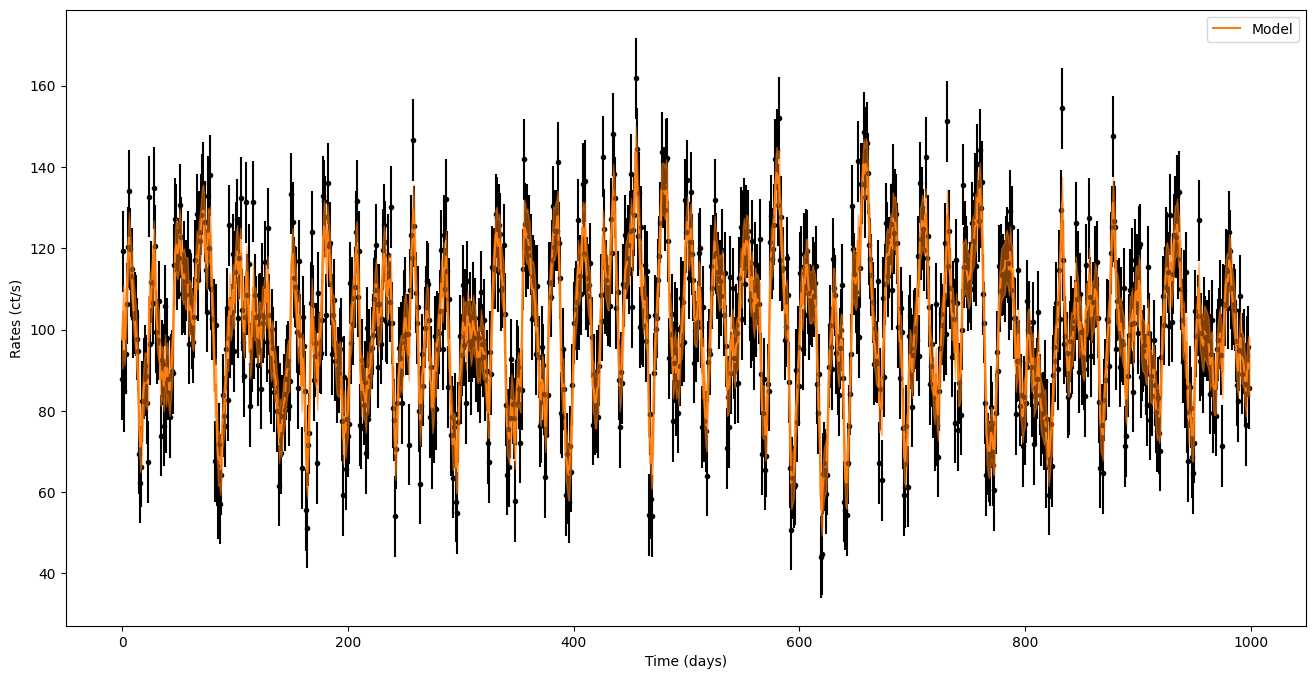

In [6]:
best_gp = gps[np.argmin(aiccs)]
print(best_gp.max_parameters)
print(f"Best model {models[np.argmin(aiccs)]} has a p-value: {pvalues[np.argmin(AICc)]:.3f}")
#print(best_gp.mcmc_samples.items())
corner_fig = corner.corner(best_gp.mcmc_samples, labels=best_gp.parameter_names, 
                           title_fmt='.1f', truths=truth,
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

plt.savefig("corner.png")
# 
best_gp.parameters = gp.max_parameters
print(best_gp.parameters)
pred_mean, pred_var = gp.predict(input_lc.y, return_var=True)
 # standarized residuals
plt.figure()
std_res = gp.standardized_residuals(include_noise=False)
plt.hist(norm.rvs(size=10000), edgecolor="black" , ls="--",
         facecolor="None", density=True, label="$N\sim(0, 1)$")
plt.hist(std_res, density="True", edgecolor="black", label="Data")
plt.xlabel("Standarized Residuals")
plt.ylabel("PDF")
plt.legend()
plt.savefig("std_res.png")
# ACF
plt.figure()
plt.acorr(std_res, maxlags=len(std_res) // 4 )
plt.xlim(0)
# 2 sigma
plt.axhspan(-1.96 / np.sqrt(len(std_res)), 1.96 / np.sqrt(len(std_res)), alpha=0.3, color="black")
plt.ylabel("ACF of Standarized Residuals")
plt.xlabel("Lags")
plt.savefig("acf.png")
# best-fit model
fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".", color="black")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")
plt.plot(times, pred_mean, label="Model", color="C1")
plt.fill_between(times, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), 
                 zorder=10, color="C1", alpha=0.5)
plt.legend()
plt.savefig("model.png")